In [3]:
import os
from keras.preprocessing import image
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to your dataset folder
dataset_path = fr'D:\Kazakh_Dataset_Gray'

# Function to load and preprocess images with data augmentation
def load_and_preprocess_images(folder_path, label, apply_augmentation=True):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = image.load_img(img_path, target_size=(150, 150), color_mode='grayscale')

        if apply_augmentation:
            # Data augmentation for images consisting of letters
            datagen = ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
            img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
            img_array = datagen.random_transform(img_array)
        else:
            # For other images, just resize and normalize
            img_array = image.img_to_array(img.resize((150, 150))) / 255.0

        images.append(img_array)
        labels.append(label)
    return images, labels

# Load images and labels
all_images = []
all_labels = []

for label, folder_name in enumerate(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder_name)
    
    # Identify images consisting of letters based on folder name or any other criterion
    apply_augmentation = "letters" in folder_name.lower()
    
    images, labels = load_and_preprocess_images(folder_path, label, apply_augmentation)
    all_images.extend(images)
    all_labels.extend(labels)

# Convert to NumPy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels, dtype=int)
#print(all_labels)
# Split the data into training, validation, and test sets
X, X_test, y, y_test = train_test_split(
    all_images, all_labels, stratify = all_labels, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify = y, random_state = 42, test_size = 0.2)

y_val_hot = keras.utils.to_categorical(y_val, num_classes = 9)
y_train_hot = keras.utils.to_categorical(y_train, num_classes = 9)
y_test_hot = keras.utils.to_categorical(y_test, num_classes = 9)


In [4]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# Define the CNN architecture
model = models.Sequential()
model.add(layers.Conv2D(64, (2, 2), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(128, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Flatten())
#model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.03)))
model.add(layers.Dense(9, activation='softmax')) #just the output size based on the number of classes

# Use the Adam optimizer with a lower learning rate
custom_optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

def lr_schedule(epoch):
    initial_lr = 1e-3
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * tf.math.exp(0.1 * (10 - epoch))

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)
checkpoint = keras.callbacks.ModelCheckpoint('letters_final.tf', save_best_only=True)

# Compile the model with the custom optimizer
model.compile(optimizer=custom_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 149, 149, 64)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       262272    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

In [5]:
# Train the model
import matplotlib.pyplot as plt
num_epochs = 50  # Adjust as needed
batch_size = 8  # Adjust as needed

history = model.fit(X_train, y_train_hot, batch_size, num_epochs, validation_data=(X_val, y_val_hot), callbacks = [checkpoint, lr_callback], verbose=1, shuffle=True)

epoch_count = range(1, len(history.history['loss']) + 1)


Epoch 1/50
97/98 [============================>.] - ETA: 0s - loss: 4.1560 - accuracy: 0.1198INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 20s 191ms/step - loss: 4.1540 - accuracy: 0.1197 - val_loss: 2.5565 - val_accuracy: 0.1128 - lr: 0.0010
Epoch 2/50
97/98 [============================>.] - ETA: 0s - loss: 2.3130 - accuracy: 0.1147INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 19s 189ms/step - loss: 2.3129 - accuracy: 0.1145 - val_loss: 2.2092 - val_accuracy: 0.1077 - lr: 0.0010
Epoch 3/50
97/98 [============================>.] - ETA: 0s - loss: 2.1603 - accuracy: 0.1559INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 19s 192ms/step - loss: 2.1606 - accuracy: 0.1557 - val_loss: 2.0724 - val_accuracy: 0.2051 - lr: 0.0010
Epoch 4/50
97/98 [============================>.] - ETA: 0s - loss: 1.8902 - accuracy: 0.2745INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 189ms/step - loss: 1.8896 - accuracy: 0.2741 - val_loss: 1.8871 - val_accuracy: 0.2974 - lr: 0.0010
Epoch 5/50
97/98 [============================>.] - ETA: 0s - loss: 1.8066 - accuracy: 0.2925INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 184ms/step - loss: 1.8069 - accuracy: 0.2921 - val_loss: 1.7151 - val_accuracy: 0.3641 - lr: 0.0010
Epoch 6/50
97/98 [============================>.] - ETA: 0s - loss: 1.6782 - accuracy: 0.3531INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 184ms/step - loss: 1.6776 - accuracy: 0.3526 - val_loss: 1.6124 - val_accuracy: 0.3795 - lr: 0.0010
Epoch 7/50
97/98 [============================>.] - ETA: 0s - loss: 1.6004 - accuracy: 0.4034INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 184ms/step - loss: 1.5998 - accuracy: 0.4028 - val_loss: 1.5320 - val_accuracy: 0.4051 - lr: 0.0010
Epoch 8/50
98/98 [==============================] - 17s 171ms/step - loss: 1.5000 - accuracy: 0.4440 - val_loss: 1.6566 - val_accuracy: 0.3487 - lr: 0.0010
Epoch 9/50
97/98 [============================>.] - ETA: 0s - loss: 1.4265 - accuracy: 0.4536INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 182ms/step - loss: 1.4264 - accuracy: 0.4543 - val_loss: 1.4688 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 10/50
97/98 [============================>.] - ETA: 0s - loss: 1.3684 - accuracy: 0.5052INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 183ms/step - loss: 1.3686 - accuracy: 0.5045 - val_loss: 1.3482 - val_accuracy: 0.5282 - lr: 0.0010
Epoch 11/50
97/98 [============================>.] - ETA: 0s - loss: 1.2198 - accuracy: 0.5876INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 186ms/step - loss: 1.2204 - accuracy: 0.5869 - val_loss: 1.3190 - val_accuracy: 0.5538 - lr: 0.0010
Epoch 12/50
97/98 [============================>.] - ETA: 0s - loss: 1.1339 - accuracy: 0.6327INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 186ms/step - loss: 1.1327 - accuracy: 0.6332 - val_loss: 1.1344 - val_accuracy: 0.6513 - lr: 9.0484e-04
Epoch 13/50
97/98 [============================>.] - ETA: 0s - loss: 0.9973 - accuracy: 0.7036INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 182ms/step - loss: 0.9970 - accuracy: 0.7040 - val_loss: 1.0132 - val_accuracy: 0.6615 - lr: 8.1873e-04
Epoch 14/50
97/98 [============================>.] - ETA: 0s - loss: 0.9602 - accuracy: 0.7332INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 184ms/step - loss: 0.9608 - accuracy: 0.7323 - val_loss: 0.9689 - val_accuracy: 0.7333 - lr: 7.4082e-04
Epoch 15/50
97/98 [============================>.] - ETA: 0s - loss: 0.8694 - accuracy: 0.7629INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 184ms/step - loss: 0.8719 - accuracy: 0.7619 - val_loss: 0.8856 - val_accuracy: 0.7538 - lr: 6.7032e-04
Epoch 16/50
98/98 [==============================] - 17s 173ms/step - loss: 0.7810 - accuracy: 0.7876 - val_loss: 0.8879 - val_accuracy: 0.7744 - lr: 6.0653e-04
Epoch 17/50
98/98 [==============================] - 17s 172ms/step - loss: 0.7558 - accuracy: 0.7992 - val_loss: 0.9599 - val_accuracy: 0.6974 - lr: 5.4881e-04
Epoch 18/50
97/98 [============================>.] - ETA: 0s - loss: 0.7104 - accuracy: 0.7977INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 181ms/step - loss: 0.7097 - accuracy: 0.7979 - val_loss: 0.7742 - val_accuracy: 0.8103 - lr: 4.9659e-04
Epoch 19/50
98/98 [==============================] - 17s 172ms/step - loss: 0.6626 - accuracy: 0.8147 - val_loss: 0.7857 - val_accuracy: 0.7795 - lr: 4.4933e-04
Epoch 20/50
97/98 [============================>.] - ETA: 0s - loss: 0.6240 - accuracy: 0.8363INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 186ms/step - loss: 0.6236 - accuracy: 0.8366 - val_loss: 0.7668 - val_accuracy: 0.8103 - lr: 4.0657e-04
Epoch 21/50
97/98 [============================>.] - ETA: 0s - loss: 0.6002 - accuracy: 0.8428INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 183ms/step - loss: 0.5999 - accuracy: 0.8430 - val_loss: 0.6793 - val_accuracy: 0.8154 - lr: 3.6788e-04
Epoch 22/50
98/98 [==============================] - 17s 171ms/step - loss: 0.5800 - accuracy: 0.8546 - val_loss: 0.7595 - val_accuracy: 0.7846 - lr: 3.3287e-04
Epoch 23/50
98/98 [==============================] - 17s 171ms/step - loss: 0.5681 - accuracy: 0.8559 - val_loss: 0.7135 - val_accuracy: 0.8359 - lr: 3.0119e-04
Epoch 24/50
97/98 [============================>.] - ETA: 0s - loss: 0.5265 - accuracy: 0.8737INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 181ms/step - loss: 0.5260 - accuracy: 0.8739 - val_loss: 0.6408 - val_accuracy: 0.8256 - lr: 2.7253e-04
Epoch 25/50
97/98 [============================>.] - ETA: 0s - loss: 0.5284 - accuracy: 0.8544INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 185ms/step - loss: 0.5284 - accuracy: 0.8546 - val_loss: 0.6366 - val_accuracy: 0.8462 - lr: 2.4660e-04
Epoch 26/50
98/98 [==============================] - 17s 172ms/step - loss: 0.4993 - accuracy: 0.8829 - val_loss: 0.6452 - val_accuracy: 0.8513 - lr: 2.2313e-04
Epoch 27/50
98/98 [==============================] - 17s 172ms/step - loss: 0.4787 - accuracy: 0.8893 - val_loss: 0.7010 - val_accuracy: 0.7949 - lr: 2.0190e-04
Epoch 28/50
98/98 [==============================] - 17s 171ms/step - loss: 0.4742 - accuracy: 0.8842 - val_loss: 0.6600 - val_accuracy: 0.8410 - lr: 1.8268e-04
Epoch 29/50
97/98 [============================>.] - ETA: 0s - loss: 0.4693 - accuracy: 0.8943INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 181ms/step - loss: 0.4689 - accuracy: 0.8945 - val_loss: 0.6137 - val_accuracy: 0.8564 - lr: 1.6530e-04
Epoch 30/50
97/98 [============================>.] - ETA: 0s - loss: 0.4516 - accuracy: 0.8918INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 186ms/step - loss: 0.4529 - accuracy: 0.8906 - val_loss: 0.5919 - val_accuracy: 0.8667 - lr: 1.4957e-04
Epoch 31/50
98/98 [==============================] - 17s 171ms/step - loss: 0.4430 - accuracy: 0.9022 - val_loss: 0.5939 - val_accuracy: 0.8513 - lr: 1.3534e-04
Epoch 32/50
97/98 [============================>.] - ETA: 0s - loss: 0.4326 - accuracy: 0.8995INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 181ms/step - loss: 0.4322 - accuracy: 0.8996 - val_loss: 0.5908 - val_accuracy: 0.8564 - lr: 1.2246e-04
Epoch 33/50
97/98 [============================>.] - ETA: 0s - loss: 0.4268 - accuracy: 0.9034INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 180ms/step - loss: 0.4264 - accuracy: 0.9035 - val_loss: 0.5875 - val_accuracy: 0.8256 - lr: 1.1080e-04
Epoch 34/50
98/98 [==============================] - 17s 170ms/step - loss: 0.4208 - accuracy: 0.9099 - val_loss: 0.5881 - val_accuracy: 0.8462 - lr: 1.0026e-04
Epoch 35/50
97/98 [============================>.] - ETA: 0s - loss: 0.4211 - accuracy: 0.9111INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 184ms/step - loss: 0.4213 - accuracy: 0.9112 - val_loss: 0.5692 - val_accuracy: 0.8769 - lr: 9.0718e-05
Epoch 36/50
98/98 [==============================] - 17s 173ms/step - loss: 0.4028 - accuracy: 0.9035 - val_loss: 0.5808 - val_accuracy: 0.8308 - lr: 8.2085e-05
Epoch 37/50
98/98 [==============================] - 17s 172ms/step - loss: 0.4064 - accuracy: 0.9125 - val_loss: 0.5807 - val_accuracy: 0.8410 - lr: 7.4274e-05
Epoch 38/50
97/98 [============================>.] - ETA: 0s - loss: 0.4044 - accuracy: 0.9201INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 183ms/step - loss: 0.4041 - accuracy: 0.9202 - val_loss: 0.5546 - val_accuracy: 0.8769 - lr: 6.7206e-05
Epoch 39/50
98/98 [==============================] - 17s 172ms/step - loss: 0.3986 - accuracy: 0.9189 - val_loss: 0.5656 - val_accuracy: 0.8513 - lr: 6.0810e-05
Epoch 40/50
98/98 [==============================] - 17s 172ms/step - loss: 0.3955 - accuracy: 0.9176 - val_loss: 0.5664 - val_accuracy: 0.8564 - lr: 5.5023e-05
Epoch 41/50
98/98 [==============================] - 17s 173ms/step - loss: 0.3909 - accuracy: 0.9086 - val_loss: 0.5566 - val_accuracy: 0.8821 - lr: 4.9787e-05
Epoch 42/50
98/98 [==============================] - 17s 172ms/step - loss: 0.3869 - accuracy: 0.9163 - val_loss: 0.5605 - val_accuracy: 0.8667 - lr: 4.5049e-05
Epoch 43/50
97/98 [============================>.] - ETA: 0s - loss: 0.3848 - accuracy: 0.9175INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 181ms/step - loss: 0.3845 - accuracy: 0.9176 - val_loss: 0.5499 - val_accuracy: 0.8667 - lr: 4.0762e-05
Epoch 44/50
98/98 [==============================] - 17s 171ms/step - loss: 0.3793 - accuracy: 0.9189 - val_loss: 0.5558 - val_accuracy: 0.8615 - lr: 3.6883e-05
Epoch 45/50
97/98 [============================>.] - ETA: 0s - loss: 0.3840 - accuracy: 0.9214INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 183ms/step - loss: 0.3836 - accuracy: 0.9215 - val_loss: 0.5477 - val_accuracy: 0.8718 - lr: 3.3373e-05
Epoch 46/50
97/98 [============================>.] - ETA: 0s - loss: 0.3763 - accuracy: 0.9214INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 183ms/step - loss: 0.3760 - accuracy: 0.9215 - val_loss: 0.5440 - val_accuracy: 0.8872 - lr: 3.0197e-05
Epoch 47/50
98/98 [==============================] - 17s 171ms/step - loss: 0.3751 - accuracy: 0.9228 - val_loss: 0.5446 - val_accuracy: 0.8615 - lr: 2.7324e-05
Epoch 48/50
98/98 [==============================] - 17s 172ms/step - loss: 0.3737 - accuracy: 0.9266 - val_loss: 0.5452 - val_accuracy: 0.8718 - lr: 2.4724e-05
Epoch 49/50
97/98 [============================>.] - ETA: 0s - loss: 0.3728 - accuracy: 0.9253INFO:tensorflow:Assets written to: letters_final.tf\assets


INFO:tensorflow:Assets written to: letters_final.tf\assets


98/98 [==============================] - 18s 182ms/step - loss: 0.3727 - accuracy: 0.9254 - val_loss: 0.5435 - val_accuracy: 0.8821 - lr: 2.2371e-05
Epoch 50/50
98/98 [==============================] - 17s 170ms/step - loss: 0.3704 - accuracy: 0.9279 - val_loss: 0.5458 - val_accuracy: 0.8872 - lr: 2.0242e-05


Text(0.5, 0, 'epoch')

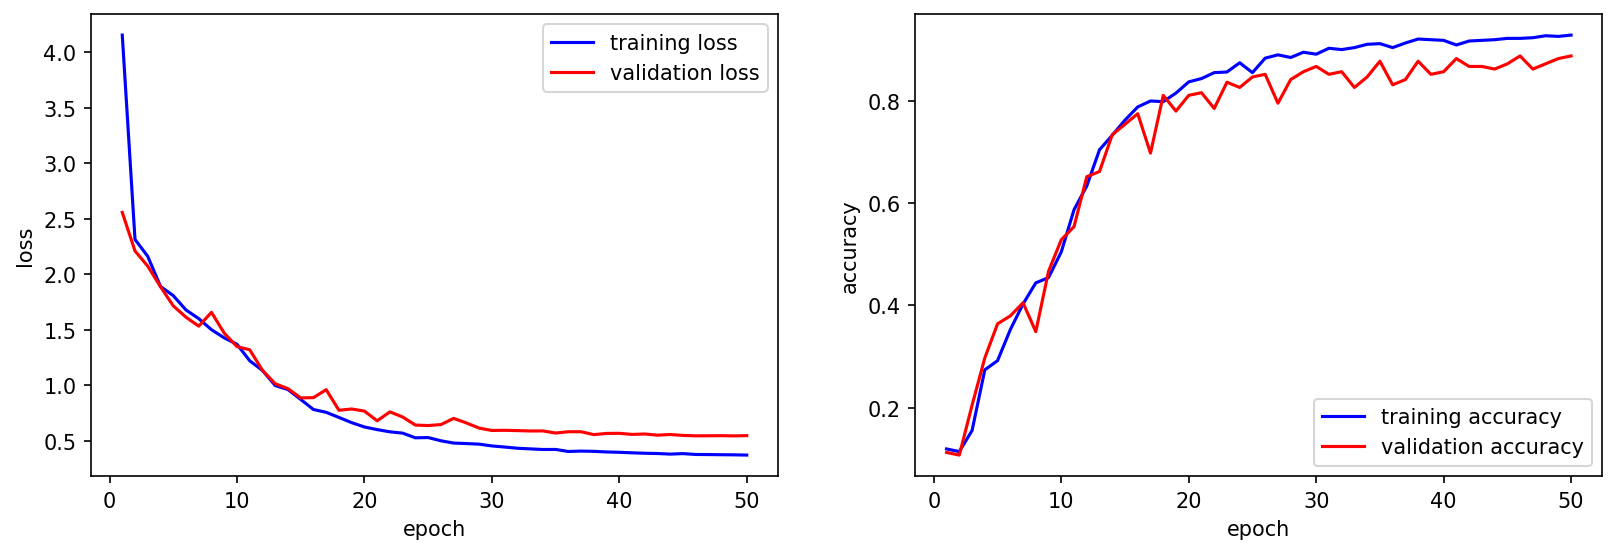

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,4), dpi=150)
plt.subplot(121)
plt.plot(epoch_count, history.history['loss'], 'b', label = 'training loss')
plt.plot(epoch_count, history.history['val_loss'], 'r', label = 'validation loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.subplot(122)
plt.plot(epoch_count, history.history['accuracy'], 'b', label = 'training accuracy')
plt.plot(epoch_count, history.history['val_accuracy'], 'r', label = 'validation accuracy')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [7]:
best_mnist_model = keras.models.load_model("letters_final.tf")
loss, accuracy = best_mnist_model.evaluate(X_test, y_test_hot, verbose=1)
print('Test accuracy of the model with the lowest loss (the best model) = {:.3f}'.format(accuracy))

11/11 [==============================] - 2s 153ms/step - loss: 0.5894 - accuracy: 0.8549
Test accuracy of the model with the lowest loss (the best model) = 0.855


11/11 [==============================] - 3s 222ms/step


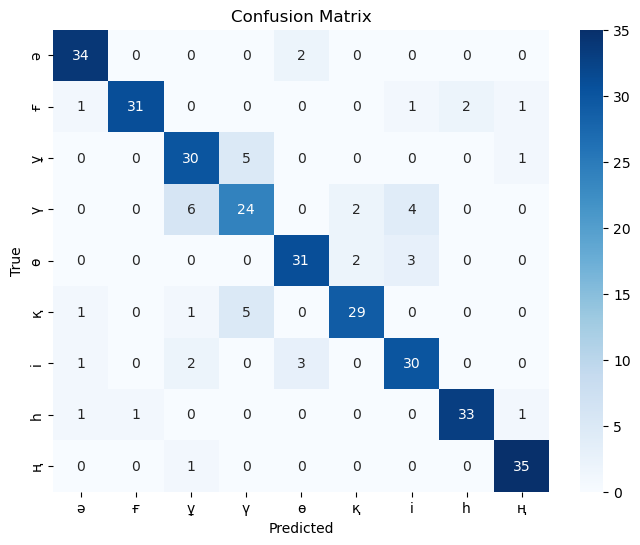

              precision    recall  f1-score   support

           ә       0.89      0.94      0.92        36
           ғ       0.97      0.86      0.91        36
           ұ       0.75      0.83      0.79        36
           ү       0.71      0.67      0.69        36
           ө       0.86      0.86      0.86        36
           қ       0.88      0.81      0.84        36
           і       0.79      0.83      0.81        36
           һ       0.94      0.92      0.93        36
           ң       0.92      0.97      0.95        36

    accuracy                           0.85       324
   macro avg       0.86      0.85      0.85       324
weighted avg       0.86      0.85      0.85       324



In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('letters_final.tf')  # Replace 'your_model.h5' with the actual filename

# Assuming you have test_images and test_labels
# If not, replace them with your actual test data
# test_images = ...
# test_labels = ...

# Normalize the test images if needed (assuming they are not normalized)
#test_images = test_images / 255.0

# Make predictions
predictions = model.predict(X_test)
# Get the predicted labels
predicted_labels = tf.argmax(predictions, axis=1).numpy()
# Calculate confusion matrix

label_mapping = {0: 'ә', 1: 'ғ', 2: 'ұ', 3: 'ү', 4: 'ө', 5: 'қ', 6: 'і', 7: 'һ', 8: 'ң'}

# Map the numeric predictions to letter labels
predicted_labels_letters = [label_mapping[label] for label in predicted_labels]

# Map the true labels to letter labels
true_labels_letters = [label_mapping[label] for label in y_test]

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels_letters, predicted_labels_letters)

# Define class labels
class_labels = list(label_mapping.values())

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_labels_letters, predicted_labels_letters, target_names=class_labels))


1/1 [==============================] - 0s 179ms/step


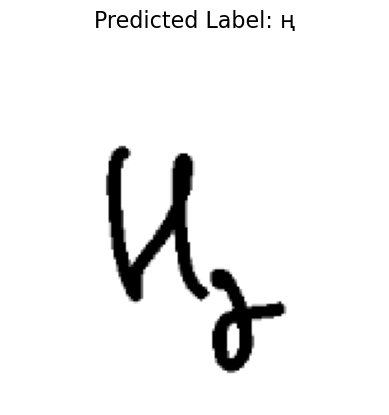

In [7]:
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model_path = 'letters_final.tf'
loaded_model = load_model(model_path)

# Function to preprocess an input image
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (150, 150))
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize pixel values to be between 0 and 1
    return img

# Replace 'path_to_test_image' with the path to the image you want to test
test_image_path = fr'D:\Kazakh_Dataset_Gray\Note Nov 15, 2025-09.png\116_35.png'

# Preprocess the test image
test_image_0 = preprocess_image(test_image_path)

# Make predictions
predictions = loaded_model.predict(test_image_0)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map the predicted class to the corresponding label
class_labels = {0: 'ә', 1: 'ғ', 2: 'ұ', 3: 'ү', 4: 'ө', 5: 'қ', 6: 'і', 7: 'h', 8: 'ң'}
predicted_label = class_labels[predicted_class]


# Load and display the input image
input_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(input_image, cmap='gray')
plt.title(f'Predicted Label: {predicted_label}', fontsize=16)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 100ms/step
Predicted Class: 6, Predicted Letter: 6


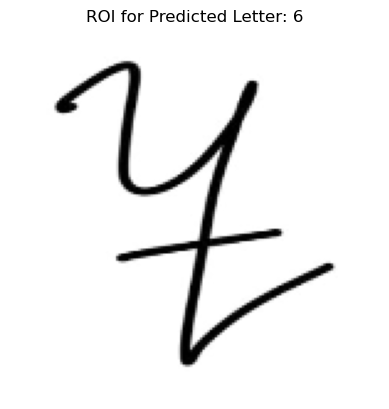

1/1 [==============================] - 0s 36ms/step
Predicted Class: 6, Predicted Letter: 6


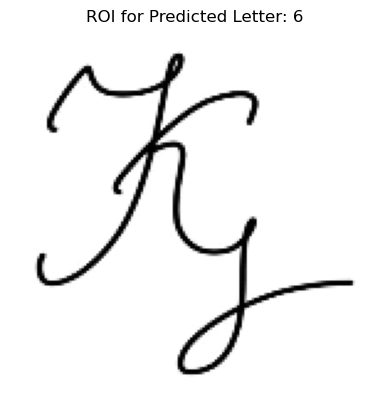

1/1 [==============================] - 0s 37ms/step
Predicted Class: 1, Predicted Letter: 1


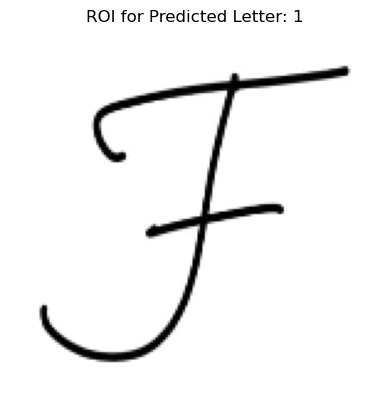

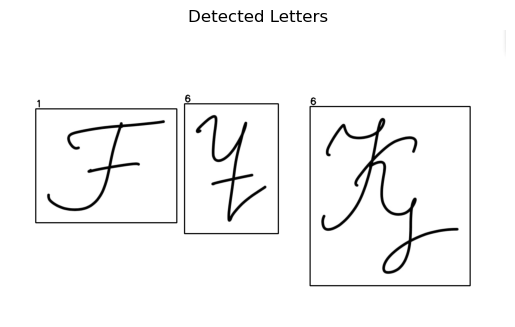

In [8]:

from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model_path = 'letters_3.tf'
loaded_model = load_model(model_path)

# Replace 'path_to_test_image' with the path to the image you want to test
test_image_path = fr'C:\Users\Tleukhan\Desktop\guk.jpg'

# Load your input image
input_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

# Threshold the image to create a binary mask
_, binary_mask = cv2.threshold(input_image, 128, 255, cv2.THRESH_BINARY_INV)

# Find connected components in the binary mask
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

# Initialize a list to store predicted letters and their bounding boxes
predicted_letters = []

# Define a margin for zooming out the detected letters
margin = 30

# Loop through each connected component (excluding background)
for label in range(1, num_labels):
    # Extract the region of interest based on the bounding box
    x, y, w, h = stats[label][:4]

    # Expand the bounding box by the defined margin
    x = max(0, x - margin)
    y = max(0, y - margin)
    w = min(input_image.shape[1] - x, w + 2 * margin)
    h = min(input_image.shape[0] - y, h + 2 * margin)

    letter_roi = input_image[y:y + h, x:x + w]
    letter_roi = cv2.resize(letter_roi, (150, 150))
    letter_roi = letter_roi / 255.0
    letter_roi = np.expand_dims(letter_roi, axis=0)
    letter_roi = np.expand_dims(letter_roi, axis=-1)

    # Predict using the loaded model
    prediction = loaded_model.predict(letter_roi)
    predicted_class = np.argmax(prediction, axis=-1)[0]
    predicted_letter = str(predicted_class)  # Convert class index to a string

    # Print prediction information for debugging
    print(f"Predicted Class: {predicted_class}, Predicted Letter: {predicted_letter}")

    # Append the predicted letter and its bounding box to the list
    predicted_letters.append((predicted_letter, (x, y, w, h)))

    # Display the letter_roi image
    plt.imshow(letter_roi.squeeze(), cmap='gray')
    plt.title(f"ROI for Predicted Letter: {predicted_letter}")
    plt.axis('off')
    plt.show()

# Draw rectangles around detected letters on the original image
output_image = input_image.copy()

for letter, (x, y, w, h) in predicted_letters:
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  
    cv2.putText(output_image, letter, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Display the result
plt.imshow(output_image, cmap='gray')
plt.title("Detected Letters")
plt.axis('off')
plt.show()


YOLO Implementation

In [ ]:
#For dataset 
import os

def list_files(directory):
    return os.listdir(directory)

# Example usage:
directory = 'D:\JamilyaYOLO\OpenLabeling\main\output\YOLO_darknet'
txt = list_files(directory)
str = "8 0.49 0.49 0.99999999 0.99999999"
for name in txt:
    file = open(os.path.join(directory, name), "w")
    file.write(str)
    file.close()

In [ ]:
from ultralytics import YOLO

# Load a model
#model = YOLO('yolov8n.yaml')  # build a new model from YAML
#model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

# Press the green button in the gutter to run the script.
if __name__ == "__main__":
    model = YOLO('yolov8s.pt')  # build from YAML and transfer weights

    # Train the model
    results = model.train(data='Jamilya.yaml', epochs=100, batch = 4) #replace to path of Yaml file 

In [ ]:
from ultralytics import YOLO
import cv2
import time

model = YOLO('best.pt')  # build from YAML and transfer weights
img = cv2.imread("test4.png")
img = cv2.resize(img, (600, 400))
results = model(source=img, show = True) #glass bottle
print(results)
time.sleep(100)